<a href="https://colab.research.google.com/github/raineseg/SciPython/blob/main/HW8_Raines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practice task for Lesson 8**

Antonec Svetlana, Raines Evgenii

GSM3215435 dataset


In [ ]:
# Install packages

!pip install --quiet scikit-learn
!pip install --quiet numpy
!pip install --quiet scanpy
!apt-get -qq install -y libarchive-dev && pip install -U libarchive
!pip install louvain
!pip install leidenalg
!pip install scikit-learn
!pip install dask



In [ ]:
# Import packages

import louvain
import leidenalg
import sklearn
import dask
import libarchive
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  


In [ ]:
# Zip data

!gzip data/features.tsv

In [ ]:
# Import data

adata = sc.read_10x_mtx('/content/data/', var_names='gene_symbols')  

In [ ]:
# Basic filtering 

sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

GENES: 
                           gene_ids    feature_types  n_cells
Mrpl15          ENSMUSG00000033845  Gene Expression     1349
Lypla1          ENSMUSG00000025903  Gene Expression     1181
Tcea1           ENSMUSG00000033813  Gene Expression     1863
Atp6v1h         ENSMUSG00000033793  Gene Expression     1329
Rb1cc1          ENSMUSG00000025907  Gene Expression      917
...                            ...              ...      ...
AC168977.2      ENSMUSG00000094915  Gene Expression       17
AC168977.1      ENSMUSG00000079808  Gene Expression       65
PISD            ENSMUSG00000095041  Gene Expression     2263
DHRSX           ENSMUSG00000063897  Gene Expression     1017
CAAA01147332.1  ENSMUSG00000095742  Gene Expression       39

[13105 rows x 3 columns] 

OBSERVATIONS: 
                     n_genes
AAACCTGAGATGCCTT-1     2218
AAACCTGAGCTAGTGG-1     1209
AAACCTGCAAGCTGTT-1     2084
AAACCTGCACCGAATT-1     1961
AAACCTGCACGCTTTC-1      908
AAACCTGCAGGACCCT-1     2985
AAACCTGGTCACAAGG-1 

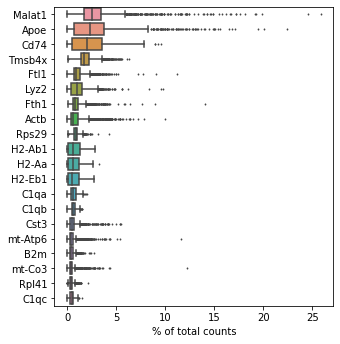

In [ ]:
# Example of genes and plot with genes with the highest regulation.

adata.obs.head(10)
print("GENES:", "\n", adata.var, "\n")
print("OBSERVATIONS:", "\n", adata.obs.head(10), "\n")
sc.pl.highest_expr_genes(adata, n_top=20, )

As we can see on the plot, there are several up-regulated genes. Let's find make a closer look at them:
- Malat1. Produces a long non-coding RNA that is cleaved into a mature, functional transcript as well as a small cytoplasmic RNA (mascRNA) (https://www.ncbi.nlm.nih.gov/gene/72289)

- Apoe. The gene encodes a member of the apolipoprotein A1/A4/E family of proteins? which are involved in the transport of lipoproteins in the blood (https://www.ncbi.nlm.nih.gov/gene/11816)

- Cd74. Part of major histocompatibility complex, class II antigen-associated (https://www.ncbi.nlm.nih.gov/gene/16149)

- Tmsb4x. Acts upstream of or within regulation of cell migration (https://www.ncbi.nlm.nih.gov/gene/19241)

- Ftl1. Part of iron ion regulation system (https://www.ncbi.nlm.nih.gov/gene/14325)

- 

In [ ]:
# Annotate the group of mitochondrial genes


adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var
print("Number of mitochondrial genes:", "\n", adata.var['mt'].value_counts())
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

Number of mitochondrial genes: 
 False    13092
True        13
Name: mt, dtype: int64


As a result of the annotation, only 13 of 13092 genes are mitochondrial genes.

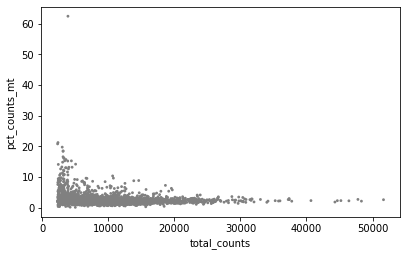

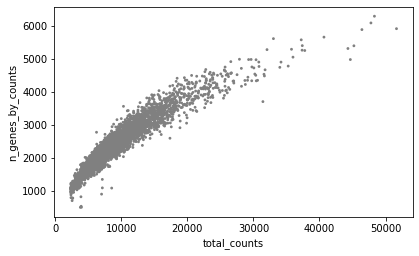

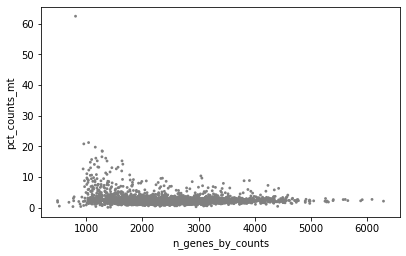

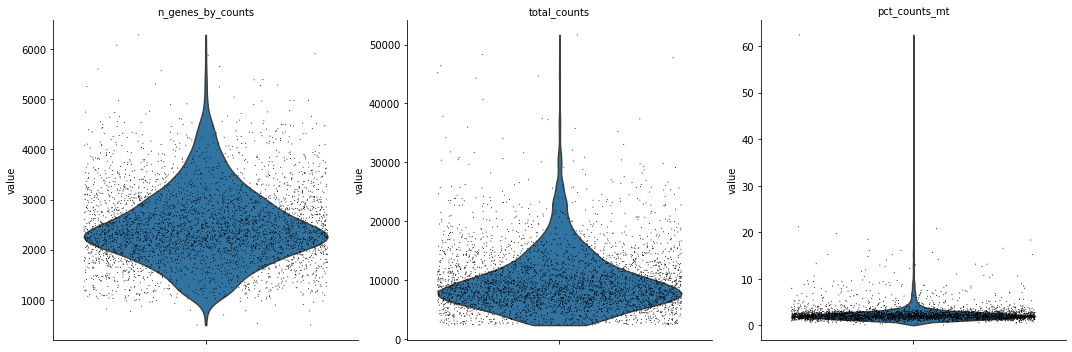

In [ ]:
# Plots

sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

Provided plots gives information about the distribition of all genes by count and mitochondrial genes by count. The information is provided in dot plots and violin plots. The informatrion is used to look at the dictribution of mitochondrial genes in dataset and choose better filters.

In [ ]:
# Filter

adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

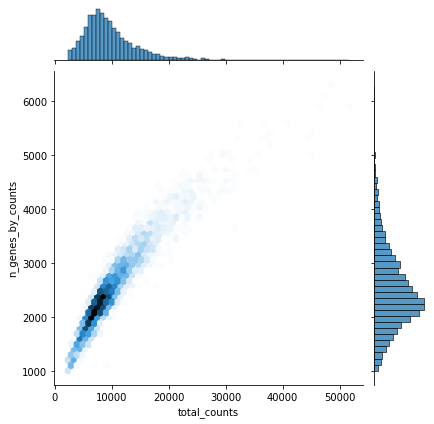

In [ ]:
# Jointplot after the filtration

import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

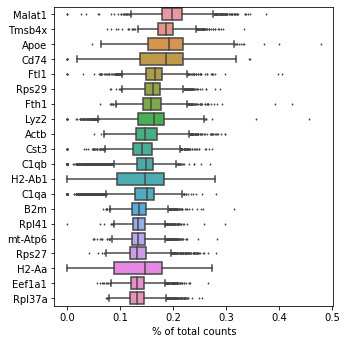

In [ ]:
# Normalize

pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])
sc.pp.normalize_total(adata, target_sum=1e4) 
sc.pp.log1p(adata)
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])
sc.pl.highest_expr_genes(adata, n_top=20, )

After the normalization it can be seen that the list of genes with the highest expression changed. For example, H2-Aa gene is now in list (enables peptide antigen binding activity, involved in response to interferon-gamma https://www.ncbi.nlm.nih.gov/gene/14960). However, the top-5 genes list didn't changed signoficantly.

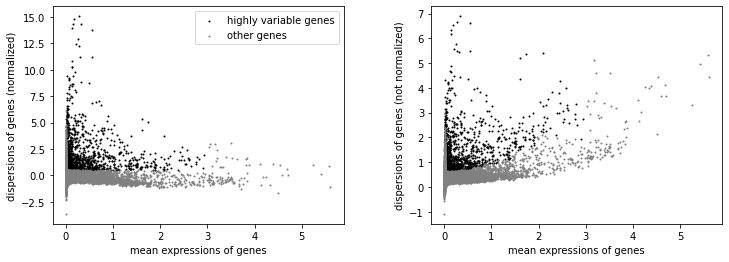

In [ ]:
# Identification of highly variable features

import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False)

The dot plot illustrated the distribution of highly variable genes.

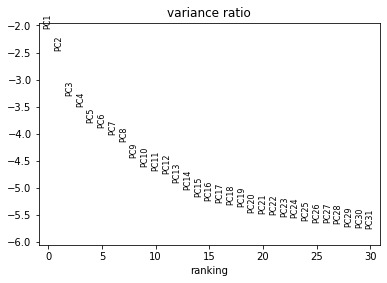

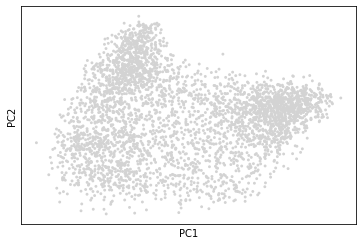

In [ ]:
# PCA dimensionality reduction

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)
sc.pl.pca(adata)

The variance ratio plot illustates the pca ranking for the dataset. Looking at the plot, we can say, that the optimal rank for PCA is 10.

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


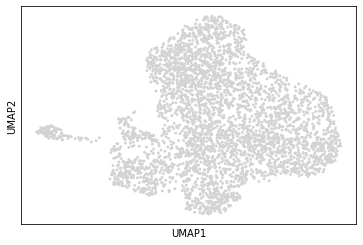

In [ ]:
# Compute neghborhood graph and embedd it using UMAP

sc.pp.neighbors(adata, n_neighbors=30, n_pcs=10)
sc.tl.umap(adata)
sc.pl.umap(adata)

At least 2 separated clusters can be seen on the UMAP plot.

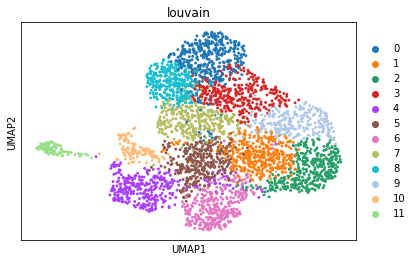

In [ ]:
#  Cell clustering

sc.tl.louvain(adata, resolution=1.2)
sc.pl.umap(adata, color='louvain')

12 clusters were constructed with the resolution 1.2.

In [ ]:
# Running DGE tests to find cluster biomarkers

sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,0,1,2,3,4,5,6,7,8,9,10,11
0,Folr2,Atf3,Ifrd1,Jun,Napsa,Hexb,Lgals3,Aif1,Pf4,Ier3,Stmn1,Cd3g


The DGE test provides data which gene marker is specific for each of the cluster. For example, Cd3g marker is specific for cluster 11. This marker is specific for T-cells, so we can say, that this cluster is for T-cells (https://www.ncbi.nlm.nih.gov/gene/12502).

Let's look at the distributions of Folr2, Atf3, Ifrd1 markers as an example.

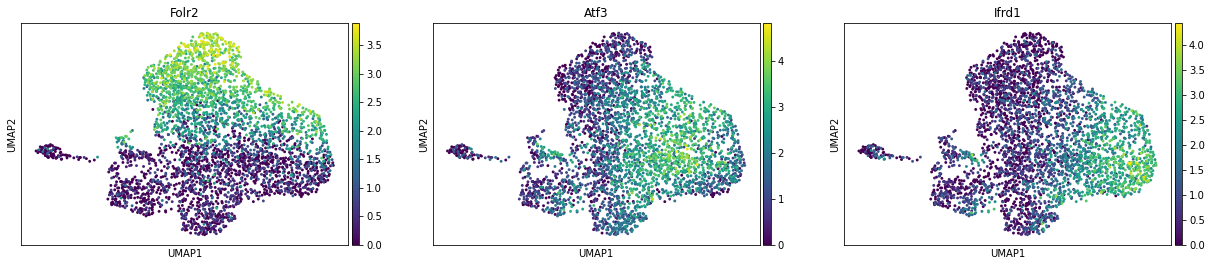

In [ ]:
sc.pl.umap(adata, color=["Folr2", "Atf3", "Ifrd1"])

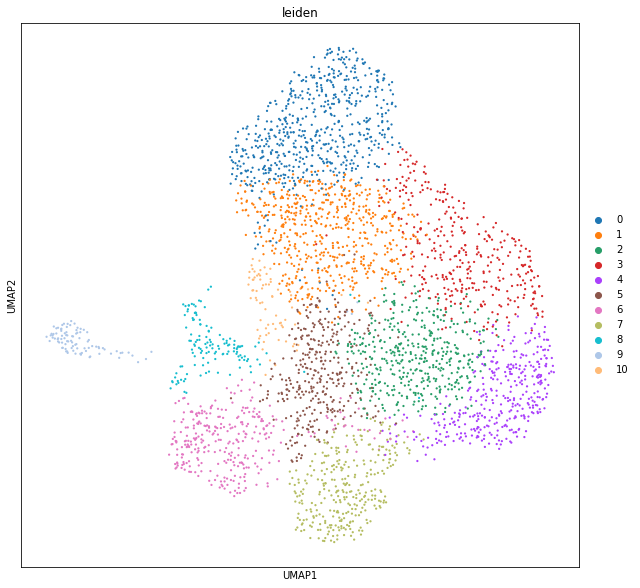

In [ ]:
# Another clustering (with lower resolution)

from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, resolution=0.7)
    sc.pl.umap(adata, color='leiden', s=20)

In [ ]:
# Extract embedding
adata.obsm
df = pd.DataFrame(adata.obsm['X_pca'])

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-9.782147,-4.836031,-2.377055,-1.583314,0.696351,-1.466231,-1.965507,-0.722408,0.908760,3.139494,...,0.583563,-0.560899,0.906958,-1.036729,-1.171195,-0.206673,-0.408988,0.740532,-0.453928,1.084192
1,-3.883418,9.840924,-7.323013,2.791461,-8.180953,0.044279,1.729870,7.658954,-0.498681,1.305792,...,-1.128360,0.548432,0.836149,0.648273,-0.301054,0.397769,-0.569397,-0.318107,-1.160867,0.184063
2,-5.497998,-7.979033,1.787935,1.133712,-3.293237,0.195706,2.291573,-3.449686,-0.066445,0.666961,...,-0.211319,0.829860,0.669394,0.511549,-1.045150,0.310171,-0.843846,-0.120248,-1.973280,0.477005
3,7.403188,-3.632700,-0.075779,0.592428,-1.471518,0.703673,-0.177621,-1.437364,0.704207,-0.749352,...,-0.861534,-0.701858,-1.431321,0.191238,-0.867634,0.889487,-0.949231,-0.140317,-0.808585,-0.714921
4,-0.775142,-5.962546,2.851030,0.697307,-3.285477,0.697993,0.554119,0.208530,2.080660,-1.125283,...,0.461042,-0.686425,0.020339,0.193830,-0.156686,-0.134606,2.738741,1.540706,-0.455039,0.151409
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,-3.261320,1.473258,-1.521026,-6.030884,-0.790383,-1.847983,0.202445,-1.169319,-1.592080,-0.183030,...,0.942182,-1.086117,-1.622877,0.722648,-0.360421,0.328471,-1.302886,-0.486157,-0.902084,0.426559
3596,8.621775,1.267774,-1.201109,0.854694,1.110113,2.685121,1.056711,-0.608654,-0.267017,1.834246,...,-0.220766,-0.948385,0.875783,-0.010398,-1.212512,0.678167,-0.028720,0.121374,-0.758085,1.956313
3597,-6.141578,1.852354,-0.874831,-5.394356,-0.841500,-2.055579,-2.100286,-1.687952,-1.285084,1.639191,...,-0.210473,0.537462,0.714148,0.480077,0.651931,0.030232,0.264392,-0.775935,0.804242,-1.255127
3598,7.561377,-3.503078,-1.073419,-1.486035,0.243521,0.947941,0.936763,0.728678,1.959532,-2.485293,...,1.510543,0.312928,-0.229330,-0.684322,-0.842148,0.125006,-0.226234,0.205164,0.246737,-0.829922


**Results**

1. The data was filtered out and then normalized with standart parameters.
2. With the UMAC the data was imbedded and then clustered effectively with 12 clusters found.
3. Found markers for each of the cluster are:  	Folr2 	Atf3 	Ifrd1 	Jun 	Napsa 	Hexb 	Lgals3 	Aif1 	Pf4 	Ier3 	Stmn1 	Cd3g
4. The markers have a specific gene expression in each of the cluster.
5. Cluster 11 was annotated as T-cells cluster,

### Comparison to publication and R:


Clustering with t-sne: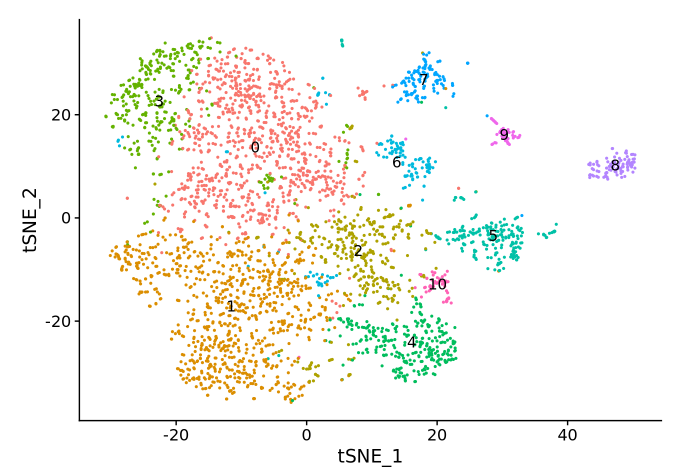

Clustering in publication: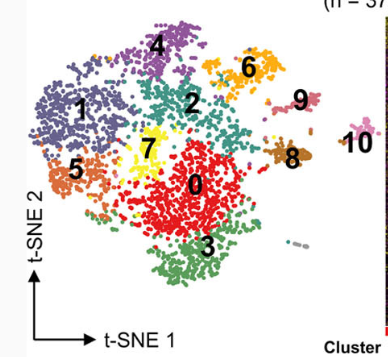

Clustering with scanpy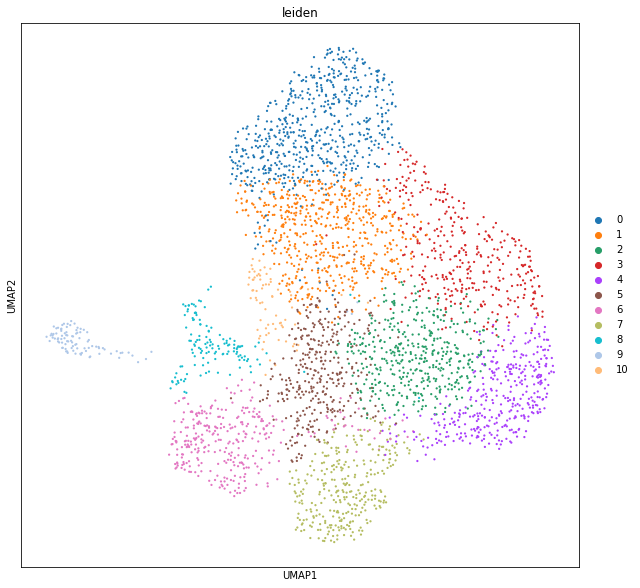

For all 3 clustering identified 10 clusters. 

In the paper mentioned, that cluster 10 is classical DC1. 
Itgae gene should be highly expressed in this cluster. 
Let's check that UMAP cluster 9 represent the same cell type

There is no such clear clustering for this gene as expected, so we can see differences in clusterisation


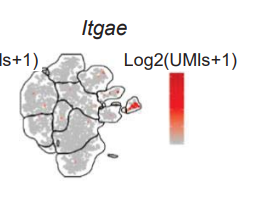
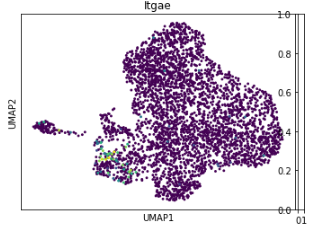

To compare more results of clustering with t-sne and publication let's build violin plots 
There is t-sne results

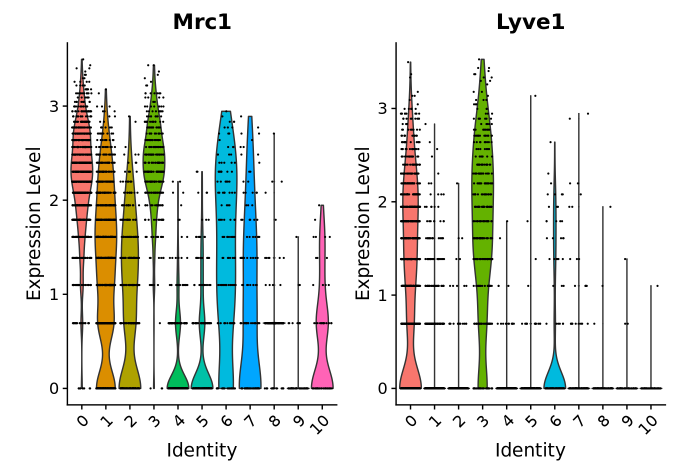

In [ ]:
sc.tl.leiden(adata, key_added='clusters', resolution=0.5)

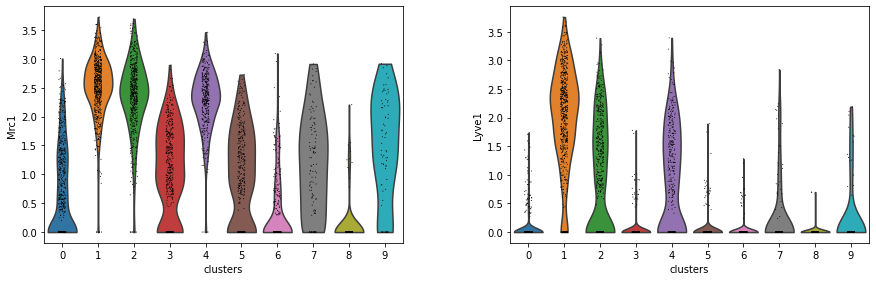

In [ ]:
with rc_context({'figure.figsize': (6, 4.5)}):
    sc.pl.violin(adata, ['Mrc1', 'Lyve1'], groupby='clusters')


After comparison we can suggest, that cluster 4 for UMAP corespond to cluster 0 for t-sne and can be the cluster of resident adventitial macrophages.

Also, as clusters 0,1,2,3,4,5,7,10 have high expression of Mrc1, they are considered macrophage clusters